In [1]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups_vectorized
from tqdm import trange

# normalize表示是否对数据归一化，这里我们保留原始数据
# data_home是数据保存路径
train_data = fetch_20newsgroups_vectorized(subset='train', 
    normalize=False, data_home='20newsgroups')
test_data = fetch_20newsgroups_vectorized(subset='test', 
    normalize=False, data_home='20newsgroups')
print('文章主题：', '\n'.join(train_data.target_names))
print(train_data.data[0])

文章主题： alt.atheism
comp.graphics
comp.os.ms-windows.misc
comp.sys.ibm.pc.hardware
comp.sys.mac.hardware
comp.windows.x
misc.forsale
rec.autos
rec.motorcycles
rec.sport.baseball
rec.sport.hockey
sci.crypt
sci.electronics
sci.med
sci.space
soc.religion.christian
talk.politics.guns
talk.politics.mideast
talk.politics.misc
talk.religion.misc
  (0, 56979)	4
  (0, 106171)	2
  (0, 129935)	2
  (0, 119977)	2
  (0, 106184)	3
  (0, 29279)	3
  (0, 111322)	1
  (0, 29403)	3
  (0, 123796)	6
  (0, 27618)	1
  (0, 92203)	2
  (0, 66608)	16
  (0, 86247)	6
  (0, 95392)	2
  (0, 101034)	1
  (0, 115475)	10
  (0, 47982)	1
  (0, 125053)	3
  (0, 76032)	1
  (0, 20228)	1
  (0, 29573)	1
  (0, 36979)	1
  (0, 40042)	1
  (0, 33764)	1
  (0, 43740)	2
  :	:
  (0, 83940)	1
  (0, 92260)	1
  (0, 81998)	1
  (0, 106239)	1
  (0, 123430)	1
  (0, 52449)	1
  (0, 117029)	1
  (0, 114520)	1
  (0, 96088)	1
  (0, 125017)	1
  (0, 53572)	1
  (0, 89503)	1
  (0, 28948)	1
  (0, 6214)	1
  (0, 109025)	1
  (0, 29400)	1
  (0, 115508)	1
  (0, 76

In [2]:
# 统计新闻主题频率
cat_cnt = np.bincount(train_data.target)
print('新闻数量：', cat_cnt)
log_cat_freq = np.log(cat_cnt / np.sum(cat_cnt))

# 对每个主题统计单词频率
alpha = 1.0
# 单词频率，20是主题个数，train_data.feature_names是分割出的单词
log_voc_freq = np.zeros((20, len(train_data.feature_names))) + alpha
# 单词计数，需要加上先验计数
voc_cnt = np.zeros((20, 1)) + len(train_data.feature_names) * alpha
# 用nonzero返回稀疏矩阵不为零的行列坐标
rows, cols = train_data.data.nonzero()
for i in trange(len(rows)):
    news = rows[i]
    voc = cols[i]
    cat = train_data.target[news] # 新闻类别
    log_voc_freq[cat, voc] += train_data.data[news, voc]
    voc_cnt[cat] += train_data.data[news, voc]

log_voc_freq = np.log(log_voc_freq / voc_cnt)

新闻数量： [480 584 591 590 578 593 585 594 598 597 600 595 591 594 593 599 546 564
 465 377]


100%|██████████████████████████████████████████████████████████████████████| 1787565/1787565 [03:30<00:00, 8505.68it/s]


In [3]:
def test_news(news):
    rows, cols = news.nonzero()
    # 对数后验
    log_post = np.copy(log_cat_freq)
    for row, voc in zip(rows, cols):
        # 加上每个单词在类别下的后验
        log_post += log_voc_freq[:, voc]
    return np.argmax(log_post)

In [4]:
preds = []
for news in test_data.data:
    preds.append(test_news(news))
acc = np.mean(np.array(preds) == test_data.target)
print('分类准确率：', acc)

分类准确率： 0.7823951141795008


In [5]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB(alpha=alpha)
mnb.fit(train_data.data, train_data.target)
print('分类准确率：', mnb.score(test_data.data, test_data.target))

分类准确率： 0.7728359001593202


In [6]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# 读取原图
orig_img = np.array(mpimg.imread('origimg.jpg'), dtype=int)
orig_img[orig_img < 128] = -1 # 黑色设置为-1
orig_img[orig_img >= 128] = 1 # 白色设置为1

# 读取带噪图像
noisy_img = np.array(mpimg.imread('noisyimg.jpg'), dtype=int)
noisy_img[noisy_img < 128] = -1
noisy_img[noisy_img >= 128] = 1

In [7]:
def compute_noise_rate(noisy, orig):
    err = np.sum(noisy != orig)
    return err / orig.size

init_noise_rate = compute_noise_rate(noisy_img, orig_img)
print (f'带噪图像与原图不一致的像素比例：{init_noise_rate * 100:.4f}%')

带噪图像与原图不一致的像素比例：9.9386%


In [8]:
# 计算坐标(i, j)处的局部能量
def compute_energy(X, Y, i, j, alpha, beta):
    # X：当前图像
    # Y：带噪图像
    energy = -beta * X[i][j] * Y[i][j]
    # 判断坐标是否超出边界
    if i > 0:
        energy -= alpha * X[i][j] * X[i - 1][j]
    if i < X.shape[0] - 1:
        energy -= alpha * X[i][j] * X[i + 1][j]
    if j > 0:
        energy -= alpha * X[i][j] * X[i][j - 1]
    if j < X.shape[1] - 1:
        energy -= alpha * X[i][j] * X[i][j + 1]
    return energy

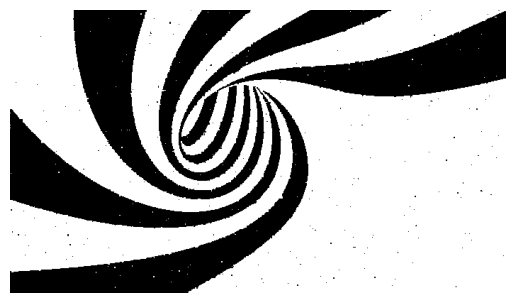

迭代轮数：0，噪声率：0.5632%


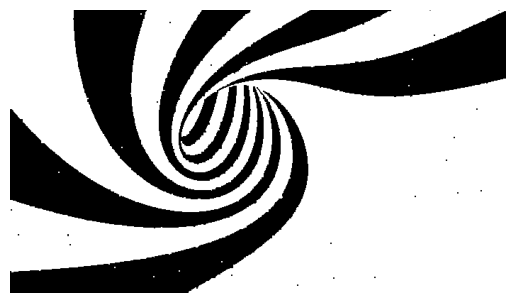

迭代轮数：1，噪声率：0.4071%


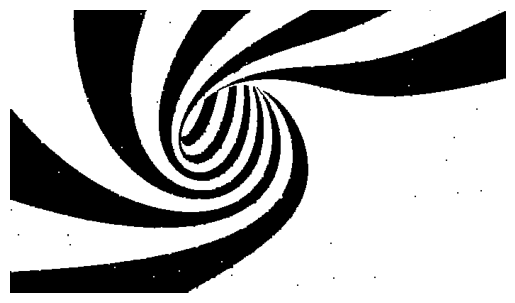

迭代轮数：2，噪声率：0.3993%


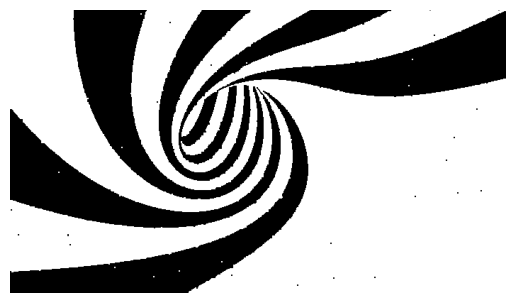

迭代轮数：3，噪声率：0.3979%


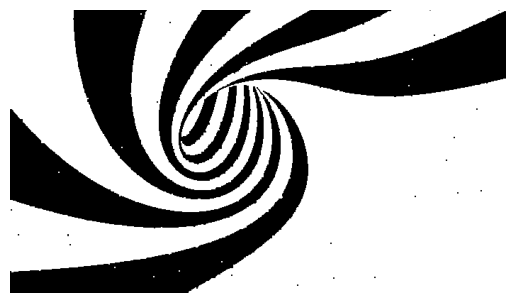

迭代轮数：4，噪声率：0.3975%


In [9]:
# 设置超参数
alpha = 2.1
beta = 1.0
max_iter = 5

# 逐像素优化
# 复制一份噪声图像，保持网络中的Y不变，只优化X
X = np.copy(noisy_img)
for k in range(max_iter):
    for i in range(X.shape[0]): # 枚举所有像素
        for j in range(X.shape[1]):
            # 分别计算当前像素取1和-1时的能量
            X[i, j] = 1
            pos_energy = compute_energy(X, noisy_img, i, j, alpha, beta)
            X[i, j] = -1
            neg_energy = compute_energy(X, noisy_img, i, j, alpha, beta)
            # 将该像素设置为使能量最低的值
            X[i, j] = 1 if pos_energy < neg_energy else -1
    
    # 展示图像并计算噪声率
    plt.figure()
    plt.axis('off')
    plt.imshow(X, cmap='binary_r')
    plt.show()
    noise_rate = compute_noise_rate(X, orig_img) * 100
    print(f'迭代轮数：{k}，噪声率：{noise_rate:.4f}%')